# Part 3

General Model: 
$$ \mu = 5 log\left( \frac{c/H_0}{10\text{pc}}(1+z)\int_0^{z} 
\frac{dz'}{\sqrt{\Omega_m(1+z'^3) + \Omega_{\Lambda}}}\right) $$

Flat Universe: $$\Omega_{\Lambda}  = 1 - \Omega_m $$

$$ \mu = 5 log\left( \frac{c/H_0}{10\text{pc}}(1+z)\int_0^{z} 
\frac{dz'}{\sqrt{\Omega_m z'^3 +  1}}\right) $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [3]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [4]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_6348\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


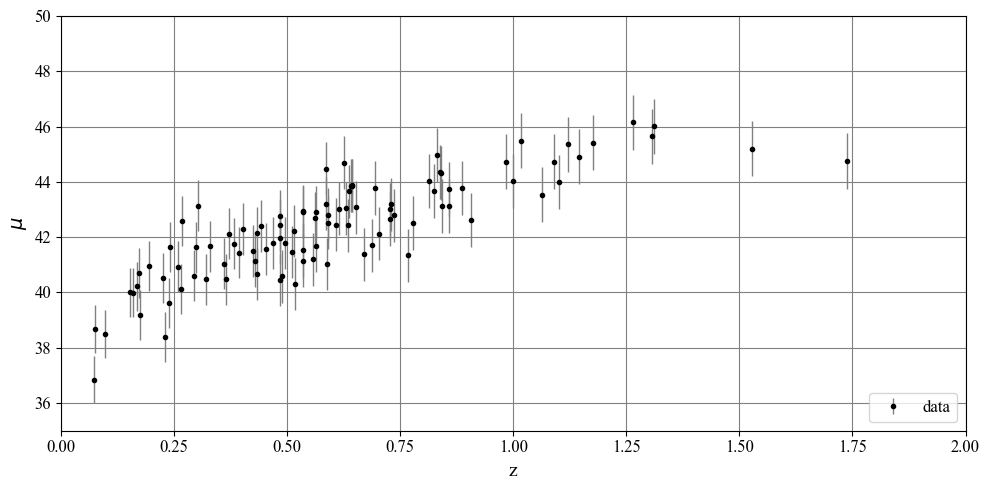

In [5]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).

# MCMC

In [6]:
from scipy.integrate import quad

c = 299792.458  # velocità della luce in km/s

def integrand(zp, omega_m):
    return 1.0 / np.sqrt(omega_m * zp**3 + 1)

def mu_theoretical(z, H0, omega_m):
    mu = []
    for zi in z:
        integral, _ = quad(integrand, 0, zi, args=(omega_m,))
        dL = (c / H0) * (1 + zi) * integral  # luminosity distance in Mpc
        mu_i = 5 * np.log10(dL * 1e6 / 10)   # convert Mpc to pc and apply modulus formula
        mu.append(mu_i)
    return np.array(mu)


In [7]:
def log_likelihood(theta):
    H0, omega_m = theta
    if H0 <= 0 or not (0 <= omega_m <= 1):
        return -np.inf
    mu_model = mu_theoretical(z_sample, H0, omega_m)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))


In [8]:
def log_prior(theta):
    H0, omega_m = theta
    if 50 < H0 < 100 and 0 < omega_m < 1:
        return 0.0
    return -np.inf


In [9]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


In [10]:
ndim = 2
nwalkers = 10
nsteps = 1000

In [11]:
initial = np.array([70, 0.3])  # H0, Omega_m
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [12]:
import emcee

In [13]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [14]:
sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


State([[80.59267939  0.29527562]
 [73.64434736  0.29516629]
 [78.89716647  0.99392441]
 [80.19727194  0.78950836]
 [75.11054227  0.24723121]
 [78.60535311  0.36742234]
 [77.59431936  0.66477022]
 [76.56379295  0.98765755]
 [74.12804923  0.65224355]
 [76.63780817  0.70121778]], log_prob=[-133.98435806 -135.64638183 -133.84820113 -133.94849576 -135.01166601
 -133.95607538 -133.88485079 -133.89175001 -134.7997705  -133.99833072], blobs=None, random_state=('MT19937', array([2594232536, 2800825278, 3587911070, 1100161605, 1805299208,
        651022644, 3332717698, 3496901777, 2001297947, 1254121743,
        521308451, 2841733277, 3658752867, 2798995221, 2109107464,
       2841021758, 2324514272, 2006901439, 3050256782, 3788214665,
       3103596556, 2539289763, 1521253718, 1726534315,  578917733,
       1832658482,  712784537, 3417322595, 3830826811, 2737893077,
       1087490361, 3067786288, 2791610611,  578565090,  919272798,
       1551326825, 4071620599, 3006223671, 4150848744, 39390862

In [15]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

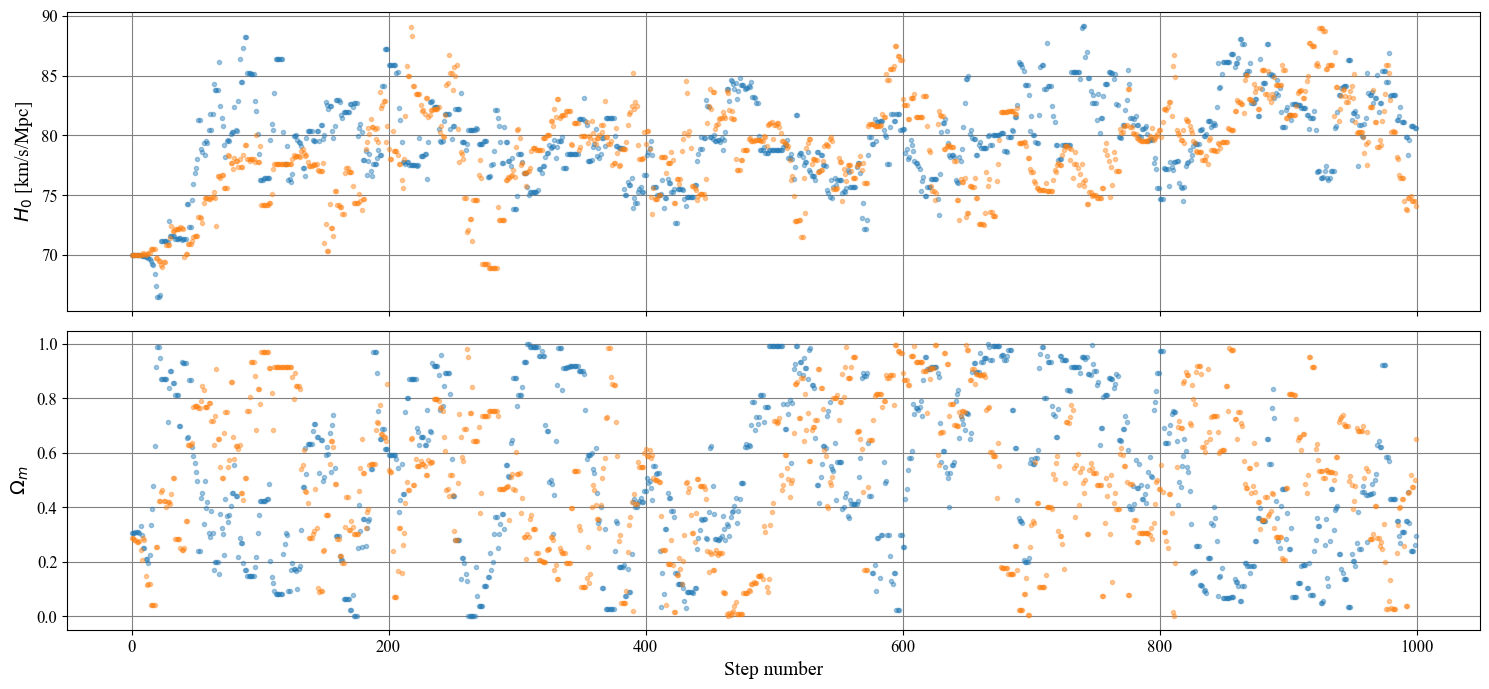

In [16]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"]

# Assuming sampler.get_chain() shape is (n_steps, n_walkers, ndim)
chain = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    # Plot every 8th walker
    for walker in range(0, chain.shape[1], 8):
        ax.plot(chain[:, walker, i], '.', alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [17]:
import corner

<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
C:\Users\ricca\AppData\Local\Temp\ipykernel_6348\2308470797.py:20: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)


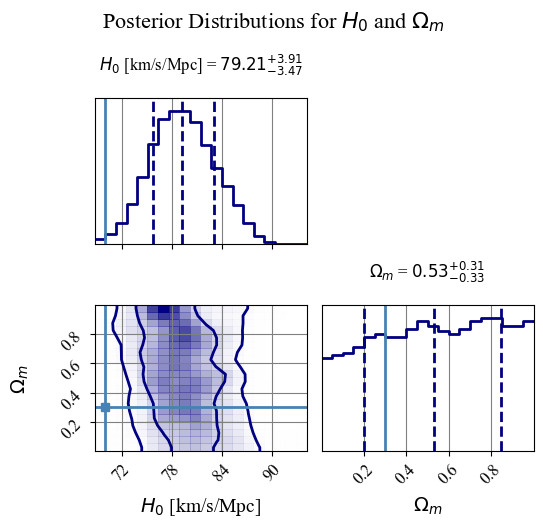

In [18]:
fig = corner.corner(
    flat_samples,
    labels=[r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"],
    truths=[70, 0.3],  # Optional: if you want to show true/expected values
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_contours=True,
    plot_density=True,
    plot_datapoints=False,  # cleaner look
    color="navy",
    smooth=1.0,  # smoothing for density
    smooth1d=1.0,
    figsize=(6, 6),
)

fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)
plt.tight_layout()
plt.show()


What are the measured value of $H_0$ and $ \Omega_m$. Are they correlated?\

In [19]:
import numpy as np

# Assuming `flat_samples` is of shape (n_samples, 2) → [H0, Omega_m]
param_names = ['H0', 'Omega']
results = []

for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results.append((mcmc[1], q[0], q[1]))
    print(f"{param_names[i]} = {mcmc[1]:.2f} (+{q[1]:.2f}, -{q[0]:.2f})")


H0 = 79.21 (+3.91, -3.47)
Omega = 0.53 (+0.31, -0.33)


In [20]:
corr_matrix = np.corrcoef(flat_samples.T)

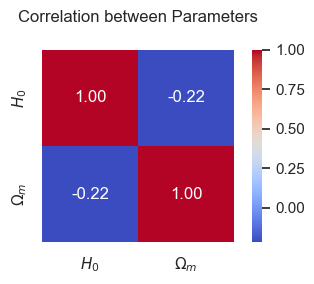

In [21]:
import seaborn as sns

sns.set(style="white")
fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            xticklabels=[r"$H_0$", r"$\Omega_m$"],
            yticklabels=[r"$H_0$", r"$\Omega_m$"],
            cmap="coolwarm", cbar=True, square=True, ax=ax)

plt.title("Correlation between Parameters")
plt.tight_layout()

In [22]:
# Generate smooth z values to plot the model line
z_fit = np.linspace(min(z_sample), max(z_sample), 200)  # or a range covering your data

In [26]:
mu_chain = []
for h0, omega_m in flat_samples[np.random.choice(len(flat_samples), 500, replace=False)]:
    mu_chain.append(mu_theoretical(z_fit, H0=h0, omega_m=omega_m))
mu_chain = np.array(mu_chain)

In [27]:
mu_median = np.median(mu_chain, axis=0)
mu_lower = np.percentile(mu_chain, 16, axis=0)
mu_upper = np.percentile(mu_chain, 84, axis=0)

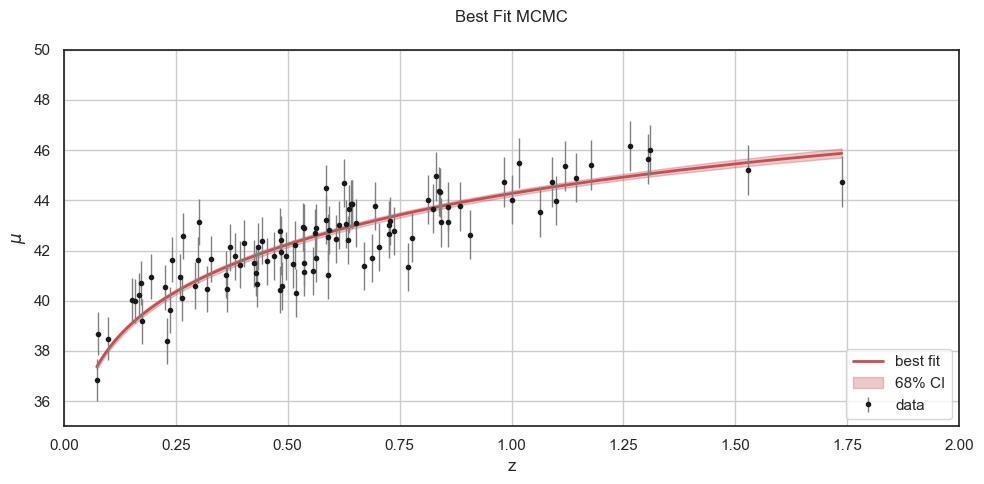

In [ ]:
plt.plot(z_fit, mu_median, lw=2, color='r', label='best fit')
plt.fill_between(z_fit, mu_lower, mu_upper, color='r', alpha=0.3, label='68% CI')
plt.title('Best Fit MCMC')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.grid(True)


In [42]:
no_omega_m = np.genfromtxt(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Arguments\ML\SN_ParamEst\omega_m_is_one.txt")

In [43]:
z_fit2 = no_omega_m.T[0]
mul = no_omega_m.T[1]
mum = no_omega_m.T[2]
mup = no_omega_m.T[3]

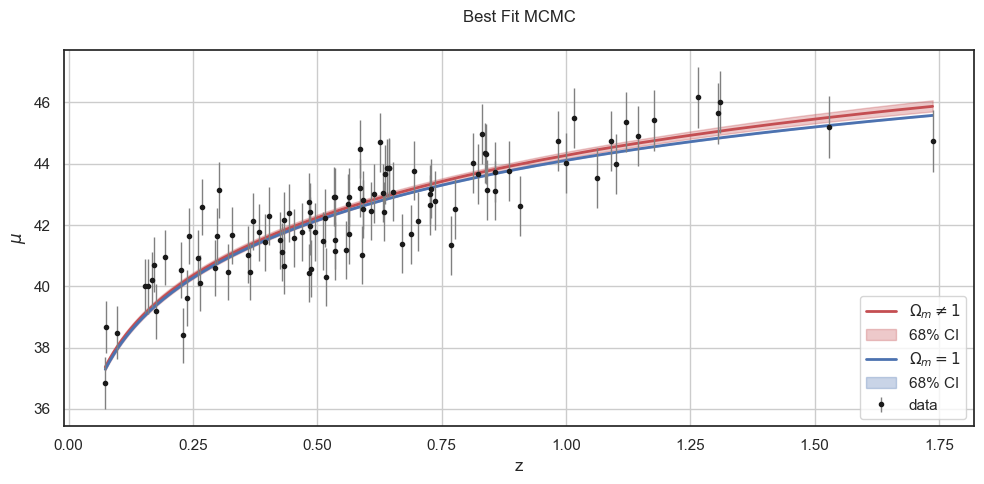

In [48]:
plt.plot(z_fit, mu_median, lw=2, color='r', label=r"$\Omega_m \neq 1$")
plt.fill_between(z_fit, mu_lower, mu_upper, color='r', alpha=0.3, label='68% CI')

plt.plot(z_fit, mum, lw=2, color='b', label=r"$\Omega_m = 1$")
plt.fill_between(z_fit, mul, mup, color='b', alpha=0.3, label='68% CI')


plt.title('Best Fit MCMC')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.grid(True)


Text(0.5, 0, 'z')

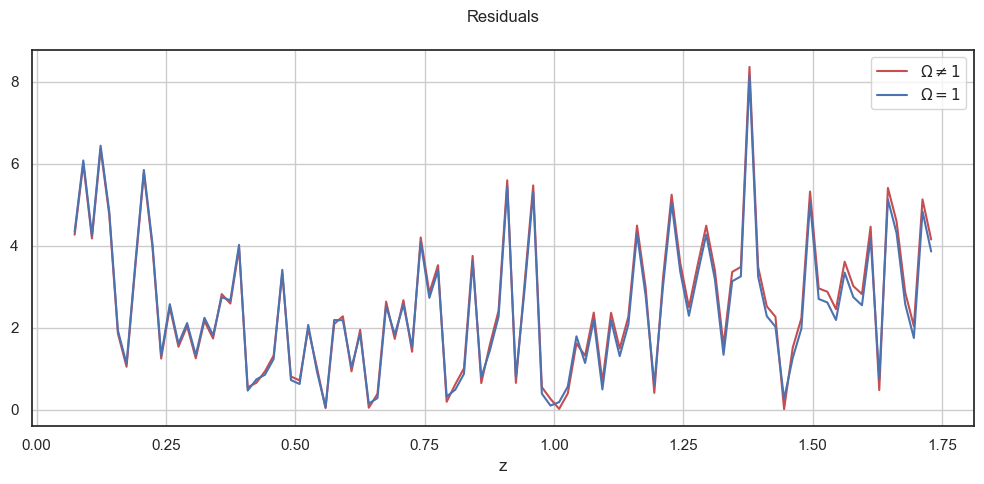

In [57]:
plt.plot(z_fit[::2], abs(mu_sample - mu_median[::2]), label=r'$\Omega \neq 1$', color='r')
plt.plot(z_fit[::2], abs(mu_sample - mum[::2]), label=r'$\Omega = 1$', color='b')
plt.legend()
plt.grid()
plt.title('Residuals')
plt.xlabel("z")

C:\Users\ricca\AppData\Local\Temp\ipykernel_6348\2226891876.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 0, 'z')

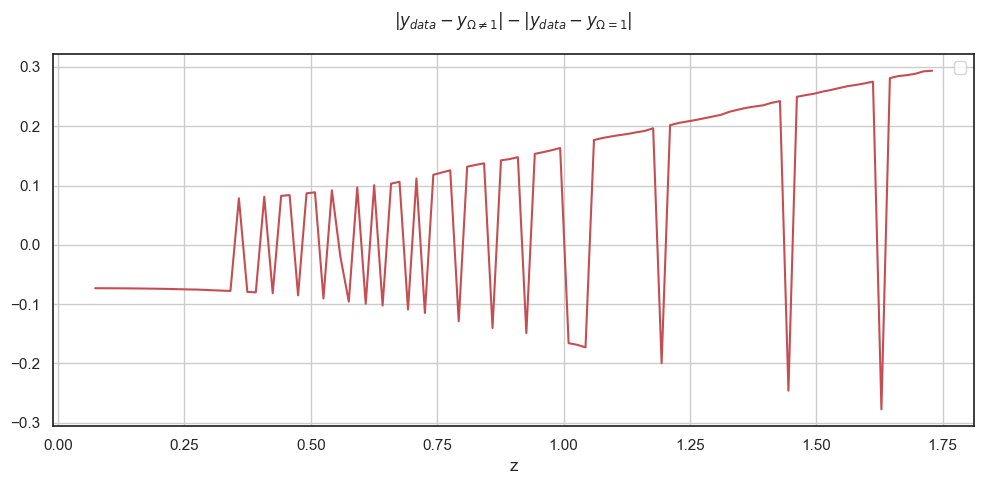

In [61]:
plt.plot(z_fit[::2], abs(mu_sample - mu_median[::2])-abs(mu_sample - mum[::2]), color='r')
plt.legend()
plt.grid()
plt.title(r"$|y_{data} - y_{\Omega \neq 1}| - |y_{data} - y_{\Omega = 1}|$")
plt.xlabel("z")

How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)